# Tutorial I: Introduction to PyTorch (torch)
<p>
Bern Winter School on Machine Learning, 2022<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this tutorial session we will get familiar wtih:
* How to do optimization in torch and what possibilities does that open to data science
* how to apply that to virtually any practical problem
   * unordered/tabular data
   * data with continuous dimensions
   * sequential data



torch provides a high-level interface, allowing easy implementation.

While it is easy to use, some fundamental conceps can remain a bit obscured, but we will try to clarify that in the course.

## 00. Requirements

To run this notebooks you need torch and numpy installed.
As some parts of this tutorial rely on specific functions, it's strongly advised to use the Chrome browser or Chromium derivatives.

Basic knowledge of Python can be acquired [here](https://docs.python.org/3/tutorial/) and of Numpy [here](https://docs.scipy.org/doc/numpy/user/quickstart.html)

Full documentation on torch functions is available in the [reference](https://pytorch.org/docs/stable/index.html).


## 0. Cell execution

> Indented block
Press ``Ctrl+Enter`` or ``Shift+Enter`` on the next cell to execute the content


In [ ]:
print('It works')

Navigate between cells with arrows. Press `Enter` to edit cell, `Esc` to exit.

## 1. Load necessary libraries

In [42]:
import os
import sys
import tarfile
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


### Download libraries

In [3]:


# URL of the file to download
url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'

# Path where the file will be saved
path = os.path.abspath('.') + '/material.tgz'

# Download the file
response = requests.get(url)
assert response.status_code == 200, "Download failed"
with open(path, 'wb') as file:
    file.write(response.content)

# Check if the path is correct
assert os.path.exists(path), "File not found"

# Extract the tar file
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

## 2. Create our first model

First we need to define the input for the model. We will create `Input`, where during the excecution we will feed in the input values.

In [27]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

    def forward(self, x):
        out1 = x + 2
        return x * out1

# Create an instance of the model
model = SimpleModel()

# Example of using the model with dummy input
input_tensor = torch.tensor(1.0)  # Example input
output = model(input_tensor)


## 3. Run the model


In [28]:

out_res = model(1)
print(out_res)


3


Several values can be computed at the same time:

In [29]:
out_val = model(torch.tensor([1, 2, 1]))
print(out_val)

tensor([3, 8, 3])


## 4. Tensor operations

For ML tasks we often need to perform operations on high-dimensional data. Theese are represented as tensors in torch. For example we can calculate sum of squared values in an 1D array with 5 elements:

In [25]:
class SimpleModel2(nn.Module):
    def __init__(self):
        super(SimpleModel2, self).__init__()

    def forward(self, x):
        out1 = x + 2
        return torch.sum(out1)


model2 = SimpleModel2()
out_val = model2(torch.tensor([1, 2, 1]))
print(out_val)

tensor(10)


Or we can do the same for several 1D arrays at once:

In [34]:
class SimpleModel3(nn.Module):
    def __init__(self):
        super(SimpleModel3, self).__init__()

    def forward(self, x):
        out1 = x + 2
        return torch.sum(out1, axis=1)


model3 = SimpleModel3()
array = torch.tensor([[1,2,1],[1,2,1],[2,1,2],[2,1,2]])
print('input shape:', array.shape)

out_vals = model3(array)
print('output shape:', out_vals.shape)
print('output:', out_vals)

input shape: torch.Size([4, 3])
output shape: torch.Size([4])
output: tensor([10, 10, 11, 11])


## 5. Exercise 1

In [35]:
torch.sum?

Modify the code bellow to calculate mean of array's elements.

In [38]:
class MeanModel(nn.Module):
    def __init__(self):
        super(MeanModel, self).__init__()

    def forward(self, x):
        return  ???

# define data:
arr = torch.tensor([[1,2,3,4,5], [2,3,4,5.1,6], [25,65,12,12,11]])

model = ???  # define model
result = ???  # run model

print(result)

tensor(10.6733)

## 6. Optimization problem

In ML we always try to optimize model parameters to minimize a loss function. pytorch provides easy interface for solving optimization problems.

Let's see how this works. We will use a function $f$, parabolic with respect to the model parameter $t$: $f(x_0, x_1|t) = (x_0*t-x_1)^2$. Here $x_0$ and $x_1$ are given values for which we will try to minimize value of function $f$ by modifying $t$.




In [44]:
class FLayer(nn.Module):
    def __init__(self):
        super(FLayer, self).__init__()
        self.t = nn.Parameter(torch.tensor(0.0))  # Initializing as a learnable parameter

    def forward(self, x):
        x0 = x[..., 0]   # the ellipsis here selects all previous dimensions as they are, and the last as dim 0
        x1 = x[..., 1]   # the ellipsis here selects all previous dimensions as they are, and the last as dim 1
        return (x0 * self.t - x1) ** 2


def loss_f(true_y, y):
  return y

For simplicity we will keep $x_0$ and $x_1$ in an array: `x` = [$x_0$, $x_1$]

In [45]:
model = FLayer()

Next we create an optimizer: object that on each iteration adjusts values of all trainable parameters (in our case just `t` to minimize the value of `f`.
Here we will use plain steepest gradient descent.

We will minimize the value of the models output.

In [46]:

# Optimizer (e.g., SGD or Adam)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Values of x0 and x1 for which we will minimize f
x0_val = torch.tensor([3.0])
x1_val = torch.tensor([9.0])
x_val = torch.stack([x0_val, x1_val], dim=-1)

# Buffers to store intermediate values of t and f to plot them later
t_sv = []
f_sv = []


# Initial evaluation
with torch.no_grad():
    f_val = model(x_val)
    t_val = model.t.item()

t_sv.append(t_val)
f_sv.append(f_val.item())

# Optimization loop
for itr in range(30):
    optimizer.zero_grad()  # Zero the gradients
    f_val = model(x_val)  # Forward pass
    loss = f_val  # Your loss function seems to just return the model output
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters

    # Logging current values of t and f
    with torch.no_grad():
        f_val = model(x_val)
        t_val = model.t.item()

    t_sv.append(t_val)
    f_sv.append(f_val.item())

<ipython-input-47-a22dd555f896>:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  f_all = np.asarray([(ti*x0_val-x1_val)*(ti*x0_val-x1_val) for ti in t_all])
<ipython-input-47-a22dd555f896>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_all = np.asarray([(ti*x0_val-x1_val)*(ti*x0_val-x1_val) for ti in t_all])


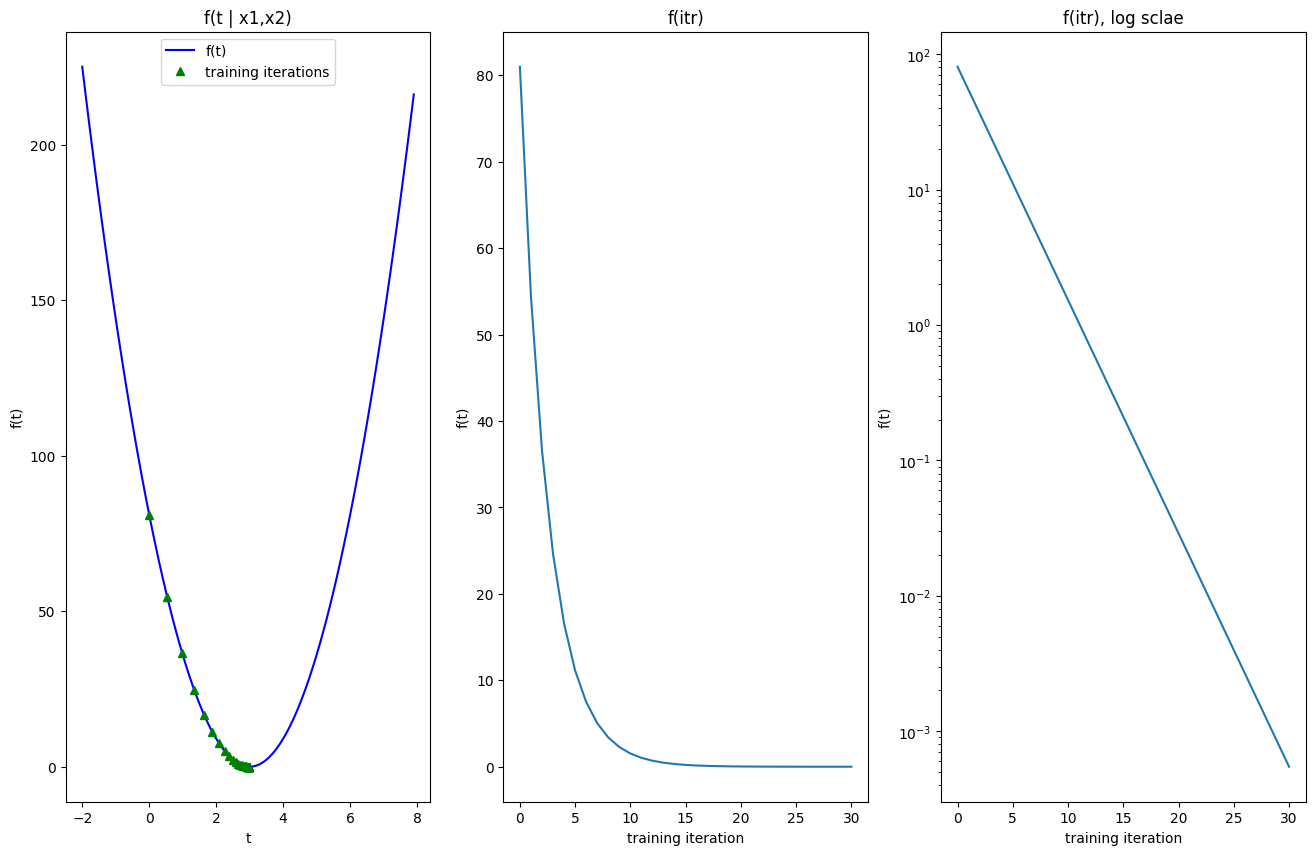

In [47]:

#just find the nice range for plotting
x0 = x1_val/x0_val
xhalf = max(abs(t_sv[0]-x0), 5.)
#fill array for parabola
t_all = np.arange(x0-xhalf, x0+xhalf, xhalf/50.)
f_all = np.asarray([(ti*x0_val-x1_val)*(ti*x0_val-x1_val) for ti in t_all])

#draw all
_, axs = plt.subplots(1, 3, figsize=(16,10))
axs[0].plot(t_all, f_all, 'b', t_sv, f_sv, 'g^')
axs[0].set_title('f(t | x1,x2)')
axs[0].set_xlabel('t')
axs[0].set_ylabel('f(t)')
axs[0].legend(('f(t)', 'training iterations'),  loc='upper center')
axs[1].plot(f_sv)
axs[1].set_title('f(itr)');
axs[1].set_ylabel('f(t)')
axs[1].set_xlabel('training iteration')
axs[2].semilogy(f_sv)
axs[2].set_title('f(itr), log sclae');
axs[2].set_ylabel('f(t)')
axs[2].set_xlabel('training iteration')
plt.show()

Of course, in the example above, we can compute the solution analytically for $(x0∗t−x1)^2$. Rewriting it for convenience as $y=(ax+b)^2 = a^2x^2 + 2abx +b^2$, we can derive the gradient $\frac{dy}{dx} = 2a^2x + 2ab$. This can be evaluated for $\frac{dy}{dx} =0$ with the values of $a=3$ and $b=-9$: $18x = 54$ so $x=3$. This confirms that our optimization process converged to the correct (analytic) solution.

In practice, the functions will not be simple, and for sure the derivation of an analytic solution will not be possible. This is why these optimization procedures are so helpful.

## 7. Exercise 2

Try to modify ``x0_val`` and ``x1_val`` in the above code, as well as the ``learning_rate`` and ``t`` initialization value, and see how it affects convergence. Get an intuition on simple example, it is very useful!

Try to see when
1. convergence is too slow
2. oscillation near minimum occurs
3. divergence
